# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
# Get the 2 label columns: Heating load and Cooling load
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2

# Function to normalize the values
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

# Function to plot true vs predicted labels
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()

# Function to plot model training metrics
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)
print(df.head())

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()
print("\ntrain_stats: \n", train_stats)

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
print("\ntrain_stats_transposed: \n", train_stats)
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

     X1     X2     X3     X4   X5  X6    X7  X8     Y1     Y2
0  0.62  808.5  367.5  220.5  3.5   5  0.40   1  17.14  17.20
1  0.76  661.5  416.5  122.5  7.0   5  0.10   3  33.24  34.50
2  0.82  612.5  318.5  147.0  7.0   2  0.25   5  25.70  26.53
3  0.82  612.5  318.5  147.0  7.0   3  0.40   1  29.91  29.13
4  0.79  637.0  343.0  147.0  7.0   3  0.40   2  43.10  39.41

train_stats: 
                X1          X2          X3          X4          X5          X6  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.764609  671.395765  319.098534  176.148616    5.272801    3.485342   
std      0.106177   88.528844   42.569256   45.072099    1.751278    1.121762   
min      0.620000  514.500000  245.000000  110.250000    3.500000    2.000000   
25%      0.690000  594.125000  294.000000  147.000000    3.500000    2.000000   
50%      0.760000  661.500000  318.500000  147.000000    7.000000    3.000000   
75%      0.850000  735.000000  343.000000  22

In [4]:
train.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'], dtype='object')

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train.columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [6]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [7]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 904us/sample - loss: 250.0084 - y1_output_loss: 118.4205 - y2_output_loss: 129.2672 - y1_output_root_mean_squared_error: 10.9342 - y2_output_root_mean_squared_error: 11.4215 - val_loss: 34.7640 - val_y1_output_loss: 13.6203 - val_y2_output_loss: 20.0398 - val_y1_output_root_mean_squared_error: 3.7463 - val_y2_output_root_mean_squared_error: 4.5530
Epoch 2/500
614/614 [==============================] - 0s 136us/sample - loss: 31.0107 - y1_output_loss: 13.1895 - y2_output_loss: 17.6452 - y1_output_root_mean_squared_error: 3.6397 - y2_output_root_mean_squared_error: 4.2147 - val_loss: 19.7622 - val_y1_output_loss: 8.0599 - val_y2_output_loss: 11.2169 - val_y1_output_root_mean_squared_error: 2.8760 - val_y2_output_root_mean_squared_error: 3.3898
Epoch 3/500
614/614 [==============================] - 0s 142us/sample - loss: 31.3426 - y1_output_loss: 11.6485 - y2_output_loss: 19.6512 - y1_

## Evaluate the Model and Plot Metrics

In [8]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 33us/sample - loss: 0.8221 - y1_output_loss: 0.1903 - y2_output_loss: 0.6287 - y1_output_root_mean_squared_error: 0.4386 - y2_output_root_mean_squared_error: 0.7935
Loss = 0.8220600718027585, Y1_loss = 0.1902860701084137, Y1_mse = 0.43859511613845825, Y2_loss = 0.628730297088623, Y2_mse = 0.7935328483581543


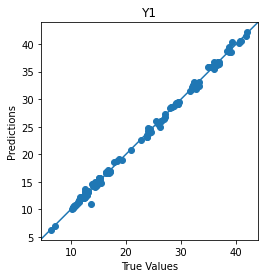

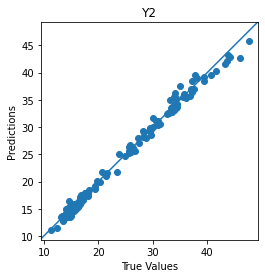

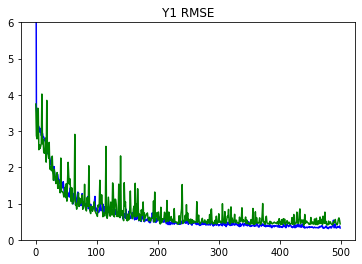

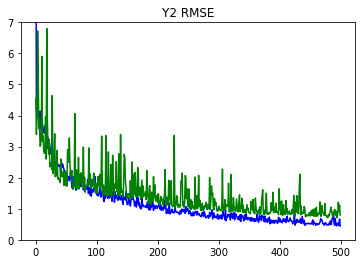

In [9]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)